In [1]:
from ftplib import FTP
import matplotlib.pyplot as plt
import pandas as pd
import gzip
from io import BytesIO
import shutil
from datetime import datetime, timedelta
import os
import seaborn as sns
import numpy as np
from glob import glob

!pip install pandarallel
from pandarallel import pandarallel

pandarallel.initialize()

  Created wheel for pandarallel: filename=pandarallel-1.4.6-py3-none-any.whl size=16086 sha256=51935e12c966c579a1e35303f835e6830d4a90aab75c51d956ef6dfdb6eddd95
  Stored in directory: /root/.cache/pip/wheels/de/92/0b/d3fbee4aafe47a742cfb5b672e5d00f9e29ac1c8c98e7998b4
Successfully built pandarallel
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
isd_history = pd.read_csv("../input/noaa-global-surface-summary-of-the-day/isd-history.csv")

In [3]:
def get_ids(icao: str):
    icao = icao.upper()
    wban = isd_history.query(f"ICAO == '{icao}'").WBAN.to_list()[0]
    usaf = isd_history.query(f"ICAO == '{icao}'").USAF.to_list()[0]
    return wban, usaf

In [4]:
years = pd.date_range(start="2006", end="2019", freq="AS")
icao = "KASH"
(wban, usaf) = get_ids(icao)

In [5]:
def get_file(year):
    filename = f"{usaf}-{wban}-{year}"
    print(filename)
    with FTP("ftp.ncdc.noaa.gov") as ftp, BytesIO() as flo:
        ftp.login()
        ftp.retrbinary(f"RETR pub/data/noaa/isd-lite/{year}/{filename}.gz", flo.write)
        flo.seek(0)
        with open(f"{filename}.gz", "wb") as fout, gzip.GzipFile(fileobj = flo) as gzipobj:
            shutil.copyfileobj(gzipobj, fout)

In [6]:
for year in list(years.year):
    get_file(year)

743946-54754-2006
743946-54754-2007
743946-54754-2008
743946-54754-2009
743946-54754-2010
743946-54754-2011
743946-54754-2012
743946-54754-2013
743946-54754-2014
743946-54754-2015
743946-54754-2016
743946-54754-2017
743946-54754-2018
743946-54754-2019


In [7]:
filelist = glob("*.gz")
df_list = []
for file in filelist:
    with open(file, "r") as f:
        df_list.append(
           pd.read_csv(
               f,
               delim_whitespace=True,
               header=None,
               names=[
                   "year",
                   "month",
                   "day",
                   "hour",
                   "tmpc",
                   "dwpc",
                   "mslp",
                   "wdir",
                   "wspd",
                   "skct",
                   "pr1h",
                   "pr6h"
               ]
           )
        )
df = pd.concat(df_list)

In [8]:
df

,year,month,day,hour,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,pr6h
0,2019,1,1,1,22,17,10235,-9999,21,-9999,-1,-9999
1,2019,1,1,2,17,17,10211,140,26,-9999,3,-9999
2,2019,1,1,3,6,6,10198,140,21,-9999,15,-9999
3,2019,1,1,4,6,6,10175,130,26,-9999,2,-9999
4,2019,1,1,5,6,6,10150,130,26,-9999,8,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...
8659,2011,12,31,19,22,11,10108,0,0,8,-9999,-9999
8660,2011,12,31,20,16,11,10109,0,0,8,-9999,-9999
8661,2011,12,31,21,22,16,10108,0,0,8,-9999,-9999
8662,2011,12,31,22,16,11,10108,0,0,8,-9999,-9999


In [9]:
df['Timestamp'] = df.parallel_apply(lambda row: datetime(row.year, row.month, row.day, row.hour) - timedelta(hours=6), 
                           axis=1)
df['Timestamp'] = pd.to_datetime(df.Timestamp)
df.index = pd.DatetimeIndex(df.Timestamp)
df = df.drop(columns='Timestamp')
df['tmpc'] /= 10.
df['dwpc'] /= 10.
df['wspd'] /= 10.
df['mslp'] /= 10.
df['pr1h'] /= 10.
df['pr6h'] /= 10.
df['doy'] = df.index.dayofyear
df['woy'] = df.index.weekofyear
# clean up missing data
df = df.mask(df.lt(-999.8),np.nan)

In [10]:
grouped_dwpc = df['dwpc'].groupby([df.index.hour,df.woy]).max(numeric_only=True)
grouped_dwpc = grouped_dwpc.unstack(level = 0)

grouped_tmpc = df['tmpc'].groupby([df.index.hour,df.woy]).max(numeric_only=True)
grouped_tmpc = grouped_tmpc.unstack(level = 0)

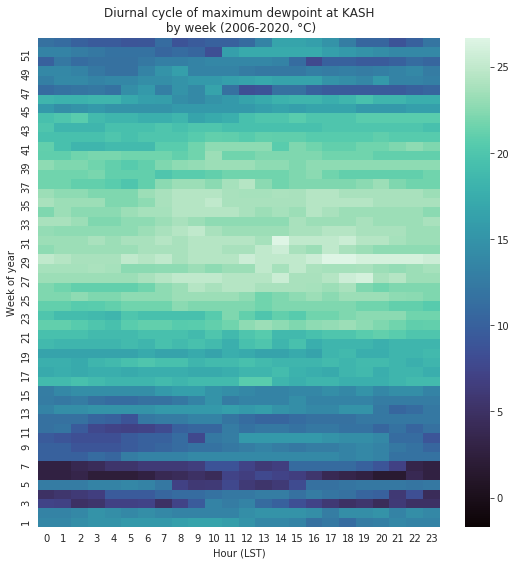

In [11]:
sns.set_style("darkgrid")
plt.figure(figsize=(9,9))
sns.heatmap(grouped_dwpc, cmap='mako')
plt.title(u'Diurnal cycle of maximum dewpoint at {}\n by week (2006-2020, °C)'.format(icao))
plt.ylabel('Week of year')
plt.ylim([0,52]) #last week is just leap years
plt.xlabel('Hour (LST)')
plt.savefig('tdmax_diur.png',dpi=200)

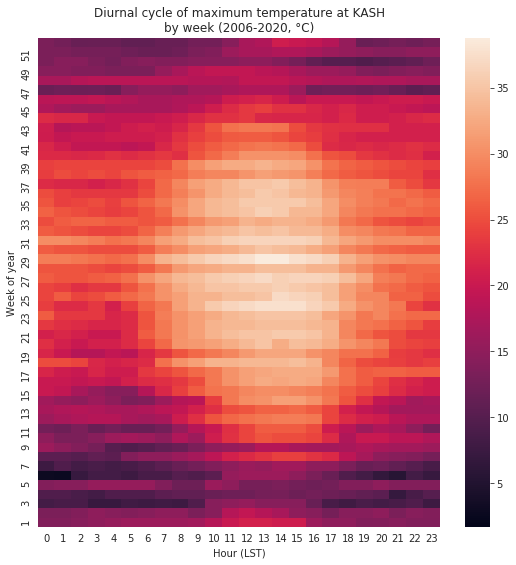

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize=(9,9))
sns.heatmap(grouped_tmpc)
plt.title(u'Diurnal cycle of maximum temperature at {}\nby week (2006-2020, °C)'.format(icao))
plt.ylabel('Week of year')
plt.ylim([0,52])
plt.xlabel('Hour (LST)')
plt.savefig('tmax_diur.png',dpi=200)